In [23]:
import numpy as np
import cv2, scipy
from matplotlib import pyplot as plt
from glob import glob
from src.tool import * 
from src.piece_process import *
from src.tile import *

In [2]:
img_paths = glob("input/*.jpg")

tiles = []

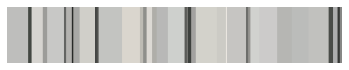

/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1902]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][2057]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[1][2057]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][2116]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1877]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[

/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][204]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1794]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][2024]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/OneDrive - Accenture/Documents - Cloud/Github/jigsaw-puzzle-solver/src/piece_process.py:62: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


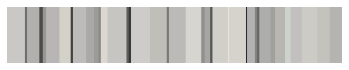

/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1881]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1979]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[1][1979]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1899]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][2193]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[

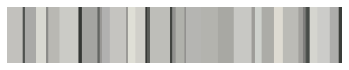

/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][2049]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][2090]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1891]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][1983]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/ji.tang/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:225: RuntimeWarning: Setting x[0][2173]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[

In [3]:
for img_path in img_paths:
    img = cv2.imread(img_path)
    img_warped = get_warp_image(img, margin=20)
    img_balanced = white_balance(img_warped)
    mask = find_outline_rough(img_balanced)
    
    img_overlap = kmeans_color_purifier(mask, img_balanced, n_clusters=40, t=0.9)
    pieces_mask, output = pieces_searching(img_overlap)
    
    pieces = []
    piece_masks = []
    for piece in pieces_mask:
        image_area = piece.shape[0] * piece.shape[1]  
        piece_mask_cropped, piece_cropped = crop_piece(piece, img_balanced)
        piece_mask_refined = refine_piece(piece_mask_cropped, image_area)
        pieces.append(piece_cropped)
        piece_masks.append(piece_mask_refined)
        
    corners = []
    for piece_mask in piece_masks:
        corners.append(get_tile_corners(piece_mask))   
    
    for i in range(len(piece_masks)):
        tiles.append(Tile(pieces[i], piece_masks[i], corners[i]))

In [4]:
b = np.ones((600*10,600*10,3), dtype=np.uint8)*255
for i, t in enumerate(tiles):
#     t.scale(0.5)
    overlay_image_alpha(b, t.img, np.array([i%10 * 600,i//10 * 600])+100-t.corners[0][0], t.mask)

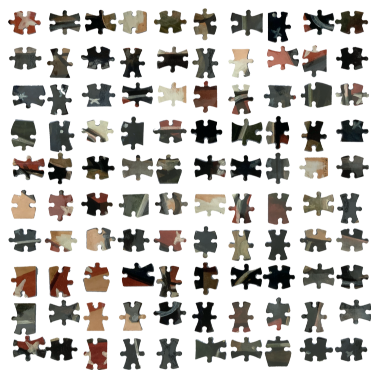

In [5]:
show([b])

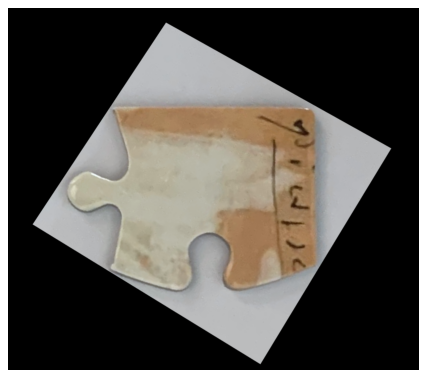

In [77]:
show([tiles[48].img])

In [7]:
import pickle
pickle.dump(tiles, open("tiles.pk", "wb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


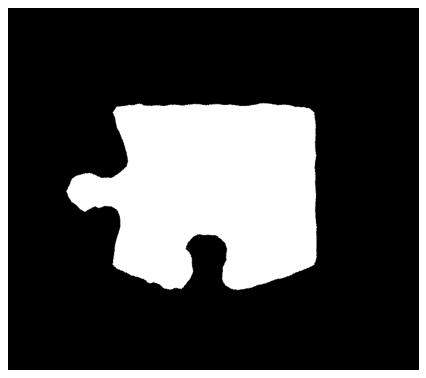

In [78]:
show([tiles[48].mask])

In [151]:
def get_smooth_contour(piece, image_area=None, n_polys=150):
    piece = piece.copy()
    piece = cv2.dilate(piece, None, iterations=3)
    piece = cv2.erode(piece, None, iterations=3)
    contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(piece, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]
    if image_area is None:
        image_area = piece.shape[0] * piece.shape[1]
    min_area = 0.0001 * image_area

    smoothened = []
    for contour in contour_info:
        if contour[1] > min_area:
            contour = contour[0]
            x,y = contour.T
            x = x.tolist()[0]
            y = y.tolist()[0]
            tck, u = splprep(np.array([x,y]), u=None, s=1.0, per=0)
            u_new = np.linspace(u.min(), u.max(), n_polys)
            x_new, y_new = splev(u_new, tck, der=0)
            res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
            smoothened = np.asarray(res_array, dtype=np.int32)
            continue
    return smoothened

def refine_piece(piece, image_area=None, n_polys=150):
    mask = np.zeros(piece.shape, dtype = np.uint8)
    smoothened = get_smooth_contour(piece, image_area=image_area, n_polys=n_polys)
    mask = cv2.fillPoly(mask, smoothened, (255))
    return mask

In [152]:
mask = tiles[41].mask.astype(np.uint8)
contour = get_smooth_contour(mask)

1


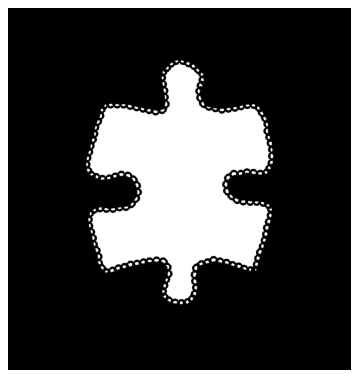

In [153]:
annotate_points(mask, contour)

In [81]:
hull = scipy.spatial.ConvexHull(contour)

In [82]:
points = list(set(hull.simplices.flatten()))

In [124]:
n_polys = 150
piece = mask.copy()
piece = cv2.dilate(piece, None, iterations=3)
piece = cv2.erode(piece, None, iterations=3)
contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(piece, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]
if image_area is None:
    image_area = piece.shape[0] * piece.shape[1]
min_area = 0.0001 * image_area

In [129]:
def get_smooth_contour(piece, image_area=None, n_polys=150):
    piece = piece.copy()
    piece = cv2.dilate(piece, None, iterations=3)
    piece = cv2.erode(piece, None, iterations=3)
    contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(piece, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]]
    if image_area is None:
        image_area = piece.shape[0] * piece.shape[1]
    min_area = 0.0001 * image_area

    smoothened = []
    for contour in contour_info:
        if contour[1] > min_area:
            contour = contour[0]
            x,y = contour.T
            print("1")
            x = x.tolist()[0]
            y = y.tolist()[0]
            tck, u = splprep([x,y], u=None, s=1.0, per=1, quiet=True)
            u_new = np.linspace(u.min(), u.max(), n_polys)
            x_new, y_new = splev(u_new, tck, der=0)
            res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
            smoothened.append(np.asarray(res_array, dtype=np.int32))
    return smoothened

def refine_piece(piece, image_area=None, n_polys=150):
    mask = np.zeros(piece.shape, dtype = np.uint8)
    smoothened = get_smooth_contour(piece, image_area=image_area, n_polys=n_polys)
    return mask

In [123]:
mask = tiles[50].mask.astype(np.uint8)

In [125]:
smoothened = []
for contour in contour_info:
    if contour[1] > min_area:
        contour = contour[0]
        

In [128]:
x,y = contour.T
x = x.tolist()[0]
y = y.tolist()[0]
tck, u = splprep([x,y], u=None, s=1.0, per=1, quiet=True)
# u_new = np.linspace(u.min(), u.max(), n_polys)
# x_new, y_new = splev(u_new, tck, der=0)
# res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
# smoothened.append(np.asarray(res_array, dtype=np.int32))

In [84]:
refine_corners(contour[points], angle_diff=10)

<ipython-input-48-6c6ac93cf06f>:6: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


array([[491, 184],
       [592, 284],
       [544, 514],
       [593, 421],
       [112, 353],
       [207, 193],
       [461, 540],
       [588, 494],
       [272, 530],
       [588, 202],
       [585, 199],
       [310, 542],
       [201, 494],
       [539, 516]], dtype=int32)

<ipython-input-48-6c6ac93cf06f>:6: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


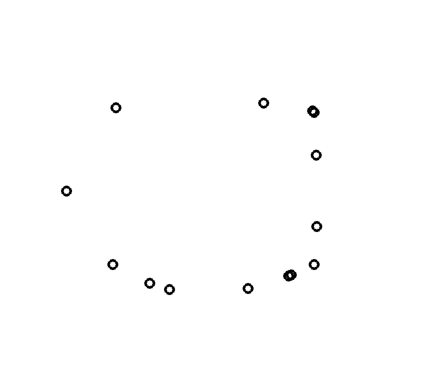

In [85]:
annotate_points(np.ones(mask.shape, dtype=np.uint8)*255, refine_corners(contour[points], angle_diff=10))

In [98]:
def get_angle(p1,p2,p3):
    """calculate angle between p2_p3 and p2_p3"""
    p2p1 = get_vector(p2,p1)
    p2p3 = get_vector(p2,p3)
    cosine_angle = np.dot(p2p1, p2p3) / (np.linalg.norm(p2p1) * np.linalg.norm(p2p3))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

In [107]:
get_smooth_contour(mask)

1


[array([[[491, 184]],
 
        [[479, 186]],
 
        [[467, 188]],
 
        [[455, 189]],
 
        [[443, 189]],
 
        [[431, 187]],
 
        [[419, 187]],
 
        [[407, 186]],
 
        [[395, 187]],
 
        [[383, 187]],
 
        [[371, 186]],
 
        [[359, 185]],
 
        [[346, 186]],
 
        [[335, 189]],
 
        [[323, 188]],
 
        [[311, 187]],
 
        [[299, 190]],
 
        [[287, 188]],
 
        [[275, 188]],
 
        [[263, 188]],
 
        [[252, 185]],
 
        [[240, 187]],
 
        [[228, 189]],
 
        [[216, 190]],
 
        [[206, 194]],
 
        [[202, 204]],
 
        [[206, 214]],
 
        [[208, 226]],
 
        [[212, 237]],
 
        [[217, 248]],
 
        [[221, 258]],
 
        [[225, 269]],
 
        [[227, 280]],
 
        [[230, 292]],
 
        [[227, 304]],
 
        [[220, 311]],
 
        [[211, 319]],
 
        [[203, 325]],
 
        [[191, 327]],
 
        [[178, 328]],
 
        [[168, 323]],
 
        [[157, 3

In [99]:
get_angle([1,0], [0,0], [0,1])

90.0

In [100]:
get_angle([1,0], [0,0], [1,1])

45.00000000000001

In [101]:
get_angle([0,1], [0,0], [1,1])

45.00000000000001

In [102]:
get_angle([0,1], [0,0], [-1,-1])

135.0

In [93]:
math.degrees(-1.2)

-68.75493541569878